In [1]:
import lsst.daf.persistence
import numpy as np
from lsst.afw.table import SOURCE_IO_NO_HEAVY_FOOTPRINTS
import tqdm

In [12]:
class ExposureProxy(object):

    def __init__(self, target):
        self.wcs = target.getWcs()
        self.ccds = target.getInfo().getCoaddInputs().ccds
        self.bbox = target.getBBox()

class Dataset(object):
    
    def __init__(self, butler, tract, patches, filter="HSC-I"):
        if not isinstance(butler, lsst.daf.persistence.Butler):
            butler = lsst.daf.persistence.Butler(butler)
        self.skyMap = butler.get("deepCoadd_skyMap")
        self.ids = {tract: list(patches)}
        self.coadds = {}
        self.catalogs = {}
        for patch in tqdm.tqdm_notebook(patches):
            try:
                self.catalogs[tract, patch] = butler.get("deepCoadd_meas", tract=tract, patch=patch, filter=filter)
                self.coadds[tract, patch] = ExposureProxy(
                    butler.get("deepCoadd_calexp", tract=tract, patch=patch, filter=filter)
                )
            except lsst.daf.persistence.NoResults:
                print "Data for tract=%d, patch=%s not found" % (tract, patch)
                self.ids[tract].remove(patch)

    def __iadd__(self, other):
        self.ids.update(other.ids)
        self.coadds.update(other.coadds)
        self.catalogs.update(other.catalogs)
        return self

In [3]:
def computeCoaddExposureTime(exposure, binsize=200):
    bbox = exposure.bbox
    results = []
    ccds = exposure.ccds
    for y0 in range(bbox.getBeginY(), bbox.getEndY(), binsize):
        y1 = min(y0 + binsize, bbox.getEndY())
        ym = 0.5*(y0 + y1)
        for x0 in range(bbox.getBeginX(), bbox.getEndX(), binsize):
            x1 = min(x0 + binsize, bbox.getEndX())
            xm = 0.5*(x0 + x1)
            overlapping = ccds.subsetContaining(lsst.afw.geom.Point2D(xm, ym), exposure.wcs,
                                                includeValidPolygon=True)
            results.append(sum(record.getVisitInfo().getExposureTime() for record in overlapping))
    return np.array(results)

In [56]:
BYTES_PER_SPAN = 3*4  # 3 int32_t
BYTES_PER_HEAVY_PIXEL = 4

def computeFootprintBytes(catalog):
    sizes = []
    for record in catalog:
        size = BYTES_PER_SPAN * len(record.getFootprint().getSpans())
        if record.getParent() != 0:
            size += BYTES_PER_HEAVY_PIXEL * record.getFootprint().getArea()
        sizes.append(size)
    return np.array(sizes, dtype=np.int64)

In [76]:
def report(dataset, min_exptime=None, min_exptime_snr=None):
    tables = []
    all_sizes = []
    for tract, patches in dataset.ids.items():
        print "tract=%4d" % tract
        print "=" * 50
        table = []
        dtype = np.dtype([("patch", str, 8), ("exptime_mean", float), ("exptime_rms", float),
                          ("size", float), ("area", float)])
        print " patch   exptime(s)    size(MB)    area(deg^2)"
        print "-" * 50
        template = "%7s  %5.0f±%3.0f      %6.2f        %6.4g"
        for patch in tqdm.tqdm_notebook(patches):
            dimensions = dataset.skyMap[tract].getPatchInnerDimensions()
            exptime = computeCoaddExposureTime(dataset.coadds[tract, patch], binsize=200)
            if min_exptime is not None and exptime.mean() < min_exptime:
                continue
            if min_exptime_snr is not None and exptime.mean() < min_exptime_snr*exptime.std():
                continue
            size = computeFootprintBytes(dataset.catalogs[tract, patch])
            area = dimensions.getX() * dimensions.getY() * \
                dataset.coadds[tract, patch].wcs.pixelScale().asDegrees()**2
            table.append((patch, exptime.mean(), exptime.std(), size.sum()*1E-6, area))
            all_sizes.append(size)
        table = np.array(table, dtype=dtype)
        for record in table:
            print template % tuple(record)
        print "-" * 50
        print template % ("avg(%2d)" % len(table), table["exptime_mean"].mean(), table["exptime_rms"].mean(),
                          table["size"].sum(), table["area"].mean())
        tables.append(table)
    return tables, np.concatenate(all_sizes)

In [72]:
reload_data = False

In [73]:
if reload_data:
    cosmos = Dataset("/tigress/HSC/HSC/rerun/lauren/LSST/DM-9862/cosmos_noJunk/",
                     tract=0,
                     patches=["%d,%d" % (i, j) for i in range(3, 8) for j in range(3, 8)])

In [74]:
udeep_tables, udeep_sizes = report(cosmos)

tract=   0
 patch   exptime(s)    size(MB)    area(deg^2)
--------------------------------------------------

    3,3   8100±873      066.43        0.03484
    3,4   8914±408      087.64        0.03484
    3,5   8878±398      085.93        0.03484
    3,6   8899±387      119.96        0.03484
    3,7   8799±390      092.99        0.03484
    4,3   8861±450      075.37        0.03484
    4,4   8975±391      089.73        0.03484
    4,5   8953±394      087.18        0.03484
    4,6   8923±382      080.20        0.03484
    4,7   9001±394      105.65        0.03484
    5,3   9012±385      079.55        0.03484
    5,4   9232±273      075.66        0.03484
    5,5   9234±318      091.55        0.03484
    5,6   9224±304      091.31        0.03484
    5,7   9269±312      084.91        0.03484
    6,3   8924±413      074.86        0.03484
    6,4   9027±342      097.31        0.03484
    6,5   9023±350      092.84        0.03484
    6,6   9009±343      088.12        0.03484
    6,7   9021±3

In [13]:
if reload_data:
    butler = lsst.daf.persistence.Butler("/tigress/HSC/HSC/rerun/hscPipe-5.0-beta1/20170322/wide/")
    wide = Dataset(butler, tract=15830,
                   patches=["%d,%d" % (i, j) for i in range(0, 8) for j in range(4, 8)])

In [14]:
if reload_data:
    wide += Dataset(butler, tract=8764,
                    patches=["%d,%d" % (i, j) for i in range(0, 8) for j in range(0, 8)])

In [16]:
if reload_data:
    wide += Dataset(butler, tract=9455,
                    patches=["%d,%d" % (i, j) for i in range(0, 8) for j in range(0, 8)])

In [75]:
wide_tables, wide_sizes = report(wide, min_exptime_snr=5)

tract=8764
 patch   exptime(s)    size(MB)    area(deg^2)
--------------------------------------------------

    0,0   1253±240      024.37        0.03484
    0,1   1537±225      028.84        0.03484
    0,2   1356±178      024.94        0.03484
    0,3   1288±179      024.74        0.03484
    0,4   1591±194      031.01        0.03484
    0,5   1308±228      022.12        0.03484
    0,6   1341±227      025.37        0.03484
    0,7   1450±257      024.62        0.03484
    1,0   1227±176      024.47        0.03484
    1,1   1381±229      027.80        0.03484
    1,2   1377±211      024.10        0.03484
    1,3   1365±172      023.27        0.03484
    1,4   1689±221      027.72        0.03484
    1,5   1434±276      024.74        0.03484
    1,7   1279±196      026.76        0.03484
    2,0   1449±195      028.22        0.03484
    2,1   1610±233      028.89        0.03484
    2,2   1436±228      027.76        0.03484
    2,3   1375±191      026.45        0.03484
    2,4   1464±1

In [77]:
table = np.concatenate(wide_tables + udeep_tables)

In [26]:
from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams['figure.figsize'] = (12, 8)

Regression: (storage-per-patch)/(MB) = nvisits * 0.149 + 18.26


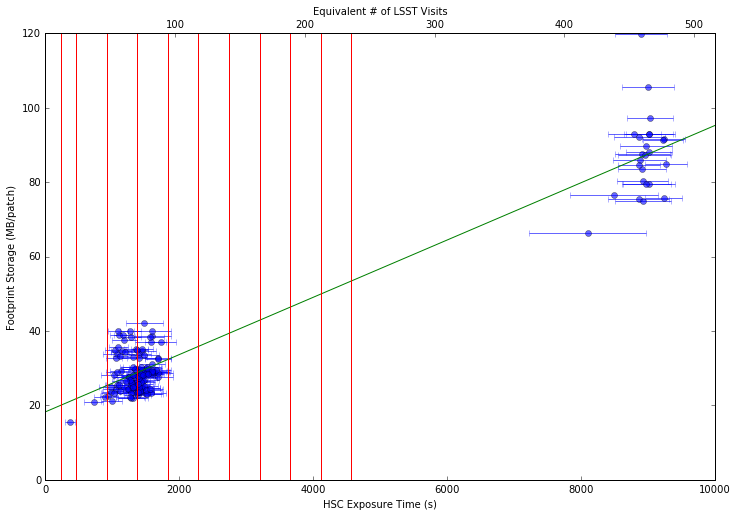

In [104]:
HSC_EXPTIME_TO_LSST_VISITS = (8.3/6.67)**2/30.0
pyplot.errorbar(table["exptime_mean"],
                table["size"],
                xerr=table["exptime_rms"], fmt='o', alpha=0.6)
m, b = np.polyfit(table["exptime_mean"], table["size"], 1)
xmax = 10000
pyplot.plot([0, xmax], [b, xmax*m + b], 'g-', label='regression')
ax1 = pyplot.gca()
ax2 = ax1.twiny()
ax1.set_xlabel("HSC Exposure Time (s)")
ax1.set_ylabel("Footprint Storage (MB/patch)")
ax2.set_xlim(HSC_EXPTIME_TO_LSST_VISITS * np.array(ax1.get_xlim()))
ax2.set_xticks([100, 200, 300, 400, 500])
ax2.set_xlabel("Equivalent # of LSST Visits")
ax2.axvline(236*0.05, color='r', label="DR1")
for i in range (1, 11):
    ax2.axvline(236*0.1*i, color='r', label="DR%d" % (i+1))
print "Regression: (storage-per-patch)/(MB) = nvisits * %5.3f + %4.2f" % (m/HSC_EXPTIME_TO_LSST_VISITS, b)

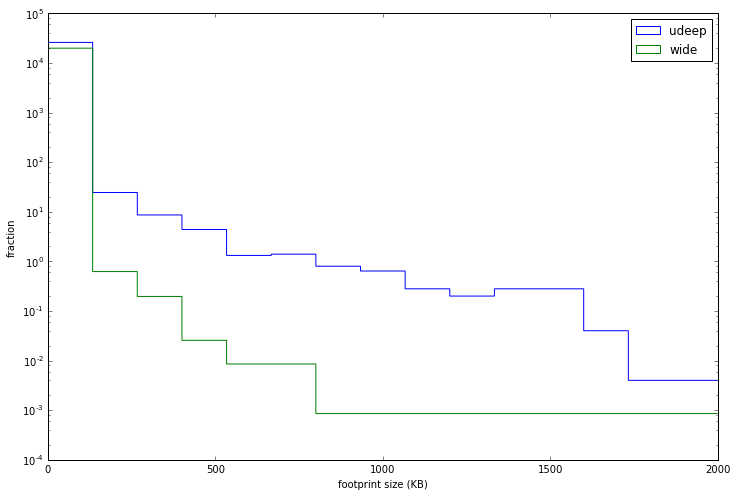

In [139]:
udeep_weights = np.array([1.0/sum(len(t) for t in udeep_tables)] * len(udeep_sizes), dtype=float)
wide_weights = np.array([1.0/sum(len(t) for t in wide_tables)] * len(wide_sizes), dtype=float)
udeep_hist = pyplot.hist(udeep_sizes*1E-3, bins=15, weights=udeep_weights,
                         range=(0, 2E3), log=True, label="udeep",histtype='step')
wide_hist = pyplot.hist(wide_sizes*1E-3, bins=15, weights=wide_weights,
                        range=(0, 2E3), log=True, label="wide", histtype='step')
pyplot.legend()
pyplot.ylabel("fraction")
pyplot.xlabel("footprint size (KB)")